# Parse Input Midi Files

Analyse Midi files to get the features I am looking for and get a few bars of melody

In [ ]:
!sudo pip install --upgrade music21

In [9]:
from music21 import *
from pprint import pprint
from fractions import Fraction
from multiprocessing import Process, Lock, Queue
from keras.utils import *


import numpy as np
import glob

In [2]:
# import data
from google.colab import drive

drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
!ls /content/gdrive/My\ Drive/training_data/130000MIDI/130000MIDI

In [ ]:
!ls /content/gdrive/My\ Drive/training_data/data -F | grep -v / | wc -l

In [ ]:
us = environment.UserSettings()
for key in sorted(us.keys()):
    if key != "localCorpusPath":
        print("Key : ", str(key), "\nValue: ", str(us[key]), "\n")

us["midiPath"] = "/usr/bin/musescore"
us["musicxmlPath"] = "/usr/bin/musescore"
us["musescoreDirectPNGPath"] = "/usr/bin/musescore"
us["lilypondPath"] = "/home/fireredninja/bin/lilypond"

In [ ]:
!ls ./data

In [2]:
!rm ./output/*.mid

In [2]:
# Look at all the functions and attributes
def printAttributesAndFunctions(object):
    for func in dir(object):
        try:
            f = getattr(object, func)
            print("---------------PASS---------------")
            if callable(f): # is it a function
                # call it
                print(f"PRINTING CALLABLE FUNCTION ----- {func}")
                pprint(eval(f'note.{func}()'), "\n\n\n")
                pass
            else:
                # just print the attribute
                print(f"PRINTING ATTRIBUTE ------ {func}")
                pprint(eval(f'note.{func}'), "\n\n\n")
                pass
        except:
            try:
                pprint(eval(f'note.{func}'), "\n\n\n")
                pass
            except:
                print("---------------FAIL---------------")
                pprint(f'{func}', "\n\n\n")
                pass

In [3]:
# transposes a score to c-major
def transpose(s):
    k = s.analyze('key')
    print(f"Transposing from {k} to C-major")
    i = interval.Interval(k.tonic, pitch.Pitch('C'))
    sNew = s.transpose(i)
    return sNew

In [4]:
# Checks if the measure contains at least one note and no chords
def metRequirements(measure):
    requirementsMet = False
    
    # Loop through all the notes
    for element in measure.__dict__["_elements"]:
        if isinstance(element, note.Note):
            if checkIfNotesBetween(element, "C4", "C9"):
                requirementsMet = True
            else:
                requirementsMet = False
                break
        elif isinstance(element, note.Rest):
            requirementsMet = True
        elif isinstance(element, chord.Chord):
            requirementsMet = False
            break

    return requirementsMet

def checkIfNotesBetween(element, note1, note2):
    if element.pitch.frequency < note.Note(note1).pitch.frequency or element.pitch.frequency > note.Note(note2).pitch.frequency:
        return False
    return True
    

In [5]:
def getTimeSignature(measure):
    if hasattr(measure, "getElementsByClass"):
        return measure.getElementsByClass(meter.TimeSignature)[0]
    else:
        return None

def checkTimeSignature(measure, tsString):
    timeSignature = getTimeSignature(measure)
    if timeSignature != None:
        if timeSignature.ratioString == tsString:
            return True
        else:
            return False
    else:
        pass

In [6]:
def writeToMidi(file, part, partCounter, noOfMeasures):
    try:
        output = stream.Score(id='mainScore')
        filePart = stream.Part(id='part0')
        filePart.append([part.measures(0,noOfMeasures)])
        output.insert(0, filePart)
        # output = transpose(output)
        filename = file[file.rfind("/"):-4] + ".mid"
        output.write(fmt="midi", fp=f"./parsedDataset/{filename}")
    except:
        pass

In [ ]:
def readMidi(score, filename):
    # Loop through all the parts in the score
    # each part is the score for an instrument
    
    print(f"Parsing {filename}")
    
    try:
        key = score.analyze('key')
        if key.mode == 'minor':
            print("minor")
            return
        score = transpose(score)
    except:
        return
    
    try:
        data = []
        for part in score.parts:
            
            # Check for nested parts
            if (hasattr(part, "parts")):
                readMidi(part)
            else:
                data += readPart(part)


        data = [x for x in data if x != []]
        
        
        i = 0
        while i < len(data):
            npArr = np.array(data[i])
            saveName = filename[filename.rfind("/")+1:-4] + str(i)
            print(f"Saving {saveName}.npy")
            np.save(f"../../data/processed/{saveName}", npArr)
            print(f" ✔️ : {saveName}.npy was saved")
            i+=1
    except:
        pass
    return
            
            
def readPart(part):    
    # holds the measures as a list
    score = []
    
    # parse the file
    if len(part.voices) > 0:
        for voice in part.voices:
            score.append(readVoices(voice))
    else:
        # keeps track of which measure we are on
        measureCounter = 0
        data = []
        print("PART----------------")
        part.measures.show()
        for measure in part.measures(0, None):
            # go though all measures and see if the key, clef or timesignature has changed
            # exit if it has
            if measureCounter == 0:
                # check if the score/measure uses the correct time signature
                if not checkTimeSignature(measure, '4/4'):
                    break
            if measureCounter > 0 and (measure.__dict__["keyIsNew"] or measure.__dict__["clefIsNew"] or measure.__dict__["timeSignatureIsNew"]):
                break
            
            data += readMeasure(measure)
            measureCounter+=1
        score.append(data)
    return score


def readVoices(voice):
    measureCounter = 0
    data = []
    
    print("VOICE------------------")
    voice.measures.show()
    for measure in voice.measures(0, None):
        # go though all measures and see if the key, clef or timesignature has changed
        # exit if it has
        if measureCounter == 0:
            # check if the score/measure uses the correct time signature
            if not checkTimeSignature(measure, '4/4'):
                break
        elif measureCounter > 0 and (measure.__dict__["keyIsNew"] or measure.__dict__["clefIsNew"] or measure.__dict__["timeSignatureIsNew"]):
            break

        
        measureData = readMeasure(measure)
        if measureData = []:
            break
        data += measureData
        measureCounter+=1
    return data


def readMeasure(measure):
    # loop over all of the measures in the score

    # check if the measure contains a note and doesn't contain chords
    if metRequirements(measure):
        
        data = measureToList(measure)
        return data
    else:
        return []

In [16]:
def createDataset(location):
    # loop through all the midi files in the location

    work_queue = Queue()

    work_lock = Lock()
    for file in glob.glob(f"{location}/**/*.mid", recursive=True):
#         work_queue.put(file)
        midi = converter.parse(file)
        readMidi(midi, file)
        

#     for i in range(4):
#         Process(target=run, args=(work_lock, work_queue)).start()
    
    return

def run(work_lock, work_queue):
    while True:
        work_lock.acquire()

        if work_queue.empty():
            work_lock.release()
            break

        file = work_queue.get()
        work_lock.release()
        
        try:
            midi = converter.parse(file)
        except:
            break

        readMidi(midi, file)
    
    print("Finished")


# Midi to Numpy

Create a numpy representation of the midi files for the Deep Learning model

In [9]:
# -------------MAIN FUNCTION--------------------
def midiToNetworkInput(midi):
    notes = getNotes(midi)
    return createNetworkInput(notes)

def partToNetworkInput(part):
    notes = getNotesFromPart(part)
    pprint(notes)
    return createNetworkInput(notes)

def measureToList(measure):
    notes = getNotes(measure)
    return createNetworkInput(notes)
    
    

# -------------HELPER FUNCTIONS-----------------
def noteToFloat(note):
    note_to_float = {'rest': 0.0, 'C0': 0.004524886877828055, 'C#0': 0.00904977375565611, 'D-0': 0.013574660633484163, 'D0': 0.01809954751131222, 'D#0': 0.02262443438914027, 'E-0': 0.027149321266968326, 'E0': 0.03167420814479638, 'F0': 0.03619909502262444, 'F#0': 0.04072398190045249, 'G-0': 0.04524886877828054, 'G0': 0.049773755656108594, 'G#0': 0.05429864253393665, 'A-0': 0.058823529411764705, 'A0': 0.06334841628959276, 'A#0': 0.06787330316742081, 'B-0': 0.07239819004524888, 'B0': 0.07692307692307693, 'C1': 0.08144796380090498, 'C#1': 0.08597285067873303, 'D-1': 0.09049773755656108, 'D1': 0.09502262443438914, 'D#1': 0.09954751131221719, 'E-1': 0.10407239819004525, 'E1': 0.1085972850678733, 'F1': 0.11312217194570136, 'F#1': 0.11764705882352941, 'G-1': 0.12217194570135746, 'G1': 0.12669683257918551, 'G#1': 0.13122171945701358, 'A-1': 0.13574660633484162, 'A1': 0.14027149321266968, 'A#1': 0.14479638009049775, 'B-1': 0.1493212669683258, 'B1': 0.15384615384615385, 'C2': 0.1583710407239819, 'C#2': 0.16289592760180996, 'D-2': 0.167420814479638, 'D2': 0.17194570135746606, 'D#2': 0.17647058823529413, 'E-2': 0.18099547511312217, 'E2': 0.18552036199095023, 'F2': 0.19004524886877827, 'F#2': 0.19457013574660634, 'G-2': 0.19909502262443438, 'G2': 0.20361990950226244, 'G#2': 0.2081447963800905, 'A-2': 0.21266968325791855, 'A2': 0.2171945701357466, 'A#2': 0.22171945701357465, 'B-2': 0.22624434389140272, 'B2': 0.23076923076923078, 'C3': 0.23529411764705882, 'C#3': 0.2398190045248869, 'D-3': 0.24434389140271492, 'D3': 0.248868778280543, 'D#3': 0.25339366515837103, 'E-3': 0.2579185520361991, 'E3': 0.26244343891402716, 'F3': 0.2669683257918552, 'F#3': 0.27149321266968324, 'G-3': 0.27601809954751133, 'G3': 0.28054298642533937, 'G#3': 0.2850678733031674, 'A-3': 0.2895927601809955, 'A3': 0.29411764705882354, 'A#3': 0.2986425339366516, 'B-3': 0.3031674208144796, 'B3': 0.3076923076923077, 'C4': 0.31221719457013575, 'C#4': 0.3167420814479638, 'D-4': 0.3212669683257919, 'D4': 0.3257918552036199, 'D#4': 0.33031674208144796, 'E-4': 0.334841628959276, 'E4': 0.3393665158371041, 'F4': 0.3438914027149321, 'F#4': 0.34841628959276016, 'G-4': 0.35294117647058826, 'G4': 0.3574660633484163, 'G#4': 0.36199095022624433, 'A-4': 0.3665158371040724, 'A4': 0.37104072398190047, 'A#4': 0.3755656108597285, 'B-4': 0.38009049773755654, 'B4': 0.38461538461538464, 'C5': 0.3891402714932127, 'C#5': 0.3936651583710407, 'D-5': 0.39819004524886875, 'D5': 0.40271493212669685, 'D#5': 0.4072398190045249, 'E-5': 0.4117647058823529, 'E5': 0.416289592760181, 'F5': 0.42081447963800905, 'F#5': 0.4253393665158371, 'G-5': 0.4298642533936652, 'G5': 0.4343891402714932, 'G#5': 0.43891402714932126, 'A-5': 0.4434389140271493, 'A5': 0.4479638009049774, 'A#5': 0.45248868778280543, 'B-5': 0.45701357466063347, 'B5': 0.46153846153846156, 'C6': 0.4660633484162896, 'C#6': 0.47058823529411764, 'D-6': 0.4751131221719457, 'D6': 0.4796380090497738, 'D#6': 0.4841628959276018, 'E-6': 0.48868778280542985, 'E6': 0.49321266968325794, 'F6': 0.497737556561086, 'F#6': 0.502262443438914, 'G-6': 0.5067873303167421, 'G6': 0.5113122171945701, 'G#6': 0.5158371040723982, 'A-6': 0.5203619909502263, 'A6': 0.5248868778280543, 'A#6': 0.5294117647058824, 'B-6': 0.5339366515837104, 'B6': 0.5384615384615384, 'C7': 0.5429864253393665, 'C#7': 0.5475113122171946, 'D-7': 0.5520361990950227, 'D7': 0.5565610859728507, 'D#7': 0.5610859728506787, 'E-7': 0.5656108597285068, 'E7': 0.5701357466063348, 'F7': 0.5746606334841629, 'F#7': 0.579185520361991, 'G-7': 0.583710407239819, 'G7': 0.5882352941176471, 'G#7': 0.5927601809954751, 'A-7': 0.5972850678733032, 'A7': 0.6018099547511312, 'A#7': 0.6063348416289592, 'B-7': 0.6108597285067874, 'B7': 0.6153846153846154, 'C8': 0.6199095022624435, 'C#8': 0.6244343891402715, 'D-8': 0.6289592760180995, 'D8': 0.6334841628959276, 'D#8': 0.6380090497737556, 'E-8': 0.6425339366515838, 'E8': 0.6470588235294118, 'F8': 0.6515837104072398, 'F#8': 0.6561085972850679, 'G-8': 0.6606334841628959, 'G8': 0.665158371040724, 'G#8': 0.669683257918552, 'A-8': 0.6742081447963801, 'A8': 0.6787330316742082, 'A#8': 0.6832579185520362, 'B-8': 0.6877828054298643, 'B8': 0.6923076923076923, 'C9': 0.6968325791855203, 'C#9': 0.7013574660633484, 'D-9': 0.7058823529411765, 'D9': 0.7104072398190046, 'D#9': 0.7149321266968326, 'E-9': 0.7194570135746606, 'E9': 0.7239819004524887, 'F9': 0.7285067873303167, 'F#9': 0.7330316742081447, 'G-9': 0.7375565610859729, 'G9': 0.7420814479638009, 'G#9': 0.746606334841629, 'A-9': 0.751131221719457, 'A9': 0.755656108597285, 'A#9': 0.7601809954751131, 'B-9': 0.7647058823529411, 'B9': 0.7692307692307693, 'C10': 0.7737556561085973, 'C#10': 0.7782805429864253, 'D-10': 0.7828054298642534, 'D10': 0.7873303167420814, 'D#10': 0.7918552036199095, 'E-10': 0.7963800904977375, 'E10': 0.8009049773755657, 'F10': 0.8054298642533937, 'F#10': 0.8099547511312217, 'G-10': 0.8144796380090498, 'G10': 0.8190045248868778, 'G#10': 0.8235294117647058, 'A-10': 0.8280542986425339, 'A10': 0.832579185520362, 'A#10': 0.8371040723981901, 'B-10': 0.8416289592760181, 'B10': 0.8461538461538461, 'C11': 0.8506787330316742, 'C#11': 0.8552036199095022, 'D-11': 0.8597285067873304, 'D11': 0.8642533936651584, 'D#11': 0.8687782805429864, 'E-11': 0.8733031674208145, 'E11': 0.8778280542986425, 'F11': 0.8823529411764706, 'F#11': 0.8868778280542986, 'G-11': 0.8914027149321267, 'G11': 0.8959276018099548, 'G#11': 0.9004524886877828, 'A-11': 0.9049773755656109, 'A11': 0.9095022624434389, 'A#11': 0.9140271493212669, 'B-11': 0.918552036199095, 'B11': 0.9230769230769231, 'C12': 0.9276018099547512, 'C#12': 0.9321266968325792, 'D-12': 0.9366515837104072, 'D12': 0.9411764705882353, 'D#12': 0.9457013574660633, 'E-12': 0.9502262443438914, 'E12': 0.9547511312217195, 'F12': 0.9592760180995475, 'F#12': 0.9638009049773756, 'G-12': 0.9683257918552036, 'G12': 0.9728506787330317, 'G#12': 0.9773755656108597, 'A-12': 0.9819004524886877, 'A12': 0.9864253393665159, 'A#12': 0.9909502262443439, 'B-12': 0.995475113122172, 'B12': 1.0}
    return note_to_float[note]

def noteToInt(note):
    note_to_int = ['rest', 'C6', 'C#6', 'D-6', 'D6', 'D#6', 'E-6', 'E6', 'F6', 'F#6', 'G-6', 'G6', 'G#6', 'A-6', 'A6', 'A#6', 'B-6', 'B6', 'C7', 'C#7', 'D-7', 'D7', 'D#7', 'E-7', 'E7', 'F7', 'F#7', 'G-7', 'G7', 'G#7', 'A-7', 'A7', 'A#7', 'B-7', 'B7', 'C8', 'C#8', 'D-8', 'D8', 'D#8', 'E-8', 'E8', 'F8', 'F#8', 'G-8', 'G8', 'G#8', 'A-8', 'A8', 'A#8', 'B-8', 'B8', 'C9']
    return note_to_int.index(note)

def getDuration(note):
    duration = note.duration.quarterLength
    if isinstance(duration, Fraction):
        return duration.numerator/duration.denominator # used to be round(duration.numerator/duration.denominator, 3)
    else:
        return duration

def getDurationAsInt(note):
    duration_list = [0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0, 6.25, 6.5, 6.75, 7.0, 7.25, 7.5, 7.75, 8.0, 8.25, 8.5, 8.75, 9.0, 9.25, 9.5, 9.75, 10.0, 10.25, 10.5, 10.75, 11.0, 11.25, 11.5, 11.75, 12.0, 12.25, 12.5, 12.75, 13.0]
    if note.duration.quarterLengthNoTuplets not in duration_list:
        return None
    return duration_list.index(note.duration.quarterLengthNoTuplets)

def createNetworkInput(notes):
    network_input = []
    for element in notes:
        durationInt = getDurationAsInt(element)
        if durationInt == None:
            break
        if element.isRest:
            network_input.append([noteToInt(element.name), durationInt])
        elif element.isNote:
            network_input.append([noteToInt(element.nameWithOctave), durationInt])
    return network_input

def getNotes(midi):
    print("getting notes")
    part = midi.notes
    midi.show()
    print(len(part))
#     part = midi.__dict__["_elements"][0].__dict__["_elements"]
    return [element for element in part if isinstance(element, note.GeneralNote)]

def getNotesFromPart(part):
    partElements = midi.__dict__["_elements"]
    return [element for element in partElements if isinstance(element, note.GeneralNote)]

def normalise(value):
    return (value-0)/(221-0)

# Numpy to Midi

Using numpy arrays from the format from before passing through the model, turn it into midi

In [10]:
# -----------------MAIN FUNCTION-----------------------
def numpyToMidi(location):
    for file in glob.glob(f'{location}*.npy'):
        arr = np.load(file)
        filename = file[file.rfind("/")+1:-4]
        numpyArrToMidi(arr, filename)

# -----------------HELPER FUNCTION---------------------
def numpyArrToMidi(npArr, filename):
    output = stream.Score(id='mainScore')
    filePart = stream.Part(id='part0')
    for note in npArr:
        noteString = arrToNoteName(note[0])
        duration = getDurationFromArray(note[1])
        noteObject = getNote(noteString, duratoin)
        filePart.append(noteObject)
    output.insert(0, filePart)
    filename = file[file.rfind("/"):-4] + ".mid"
    output.write(fmt="midi", fp=f"./output/{filename}")

def getNote(noteString, duration):
    if noteString != 'rest':
        noteObject = note.Note(noteString)
        noteObject.duration.quarterLength = duration
        return noteObject
    else:
        return note.Rest()
    
def floatToNoteName(value):
    note_to_float = {'rest': 0.0, 'C0': 0.004524886877828055, 'C#0': 0.00904977375565611, 'D-0': 0.013574660633484163, 'D0': 0.01809954751131222, 'D#0': 0.02262443438914027, 'E-0': 0.027149321266968326, 'E0': 0.03167420814479638, 'F0': 0.03619909502262444, 'F#0': 0.04072398190045249, 'G-0': 0.04524886877828054, 'G0': 0.049773755656108594, 'G#0': 0.05429864253393665, 'A-0': 0.058823529411764705, 'A0': 0.06334841628959276, 'A#0': 0.06787330316742081, 'B-0': 0.07239819004524888, 'B0': 0.07692307692307693, 'C1': 0.08144796380090498, 'C#1': 0.08597285067873303, 'D-1': 0.09049773755656108, 'D1': 0.09502262443438914, 'D#1': 0.09954751131221719, 'E-1': 0.10407239819004525, 'E1': 0.1085972850678733, 'F1': 0.11312217194570136, 'F#1': 0.11764705882352941, 'G-1': 0.12217194570135746, 'G1': 0.12669683257918551, 'G#1': 0.13122171945701358, 'A-1': 0.13574660633484162, 'A1': 0.14027149321266968, 'A#1': 0.14479638009049775, 'B-1': 0.1493212669683258, 'B1': 0.15384615384615385, 'C2': 0.1583710407239819, 'C#2': 0.16289592760180996, 'D-2': 0.167420814479638, 'D2': 0.17194570135746606, 'D#2': 0.17647058823529413, 'E-2': 0.18099547511312217, 'E2': 0.18552036199095023, 'F2': 0.19004524886877827, 'F#2': 0.19457013574660634, 'G-2': 0.19909502262443438, 'G2': 0.20361990950226244, 'G#2': 0.2081447963800905, 'A-2': 0.21266968325791855, 'A2': 0.2171945701357466, 'A#2': 0.22171945701357465, 'B-2': 0.22624434389140272, 'B2': 0.23076923076923078, 'C3': 0.23529411764705882, 'C#3': 0.2398190045248869, 'D-3': 0.24434389140271492, 'D3': 0.248868778280543, 'D#3': 0.25339366515837103, 'E-3': 0.2579185520361991, 'E3': 0.26244343891402716, 'F3': 0.2669683257918552, 'F#3': 0.27149321266968324, 'G-3': 0.27601809954751133, 'G3': 0.28054298642533937, 'G#3': 0.2850678733031674, 'A-3': 0.2895927601809955, 'A3': 0.29411764705882354, 'A#3': 0.2986425339366516, 'B-3': 0.3031674208144796, 'B3': 0.3076923076923077, 'C4': 0.31221719457013575, 'C#4': 0.3167420814479638, 'D-4': 0.3212669683257919, 'D4': 0.3257918552036199, 'D#4': 0.33031674208144796, 'E-4': 0.334841628959276, 'E4': 0.3393665158371041, 'F4': 0.3438914027149321, 'F#4': 0.34841628959276016, 'G-4': 0.35294117647058826, 'G4': 0.3574660633484163, 'G#4': 0.36199095022624433, 'A-4': 0.3665158371040724, 'A4': 0.37104072398190047, 'A#4': 0.3755656108597285, 'B-4': 0.38009049773755654, 'B4': 0.38461538461538464, 'C5': 0.3891402714932127, 'C#5': 0.3936651583710407, 'D-5': 0.39819004524886875, 'D5': 0.40271493212669685, 'D#5': 0.4072398190045249, 'E-5': 0.4117647058823529, 'E5': 0.416289592760181, 'F5': 0.42081447963800905, 'F#5': 0.4253393665158371, 'G-5': 0.4298642533936652, 'G5': 0.4343891402714932, 'G#5': 0.43891402714932126, 'A-5': 0.4434389140271493, 'A5': 0.4479638009049774, 'A#5': 0.45248868778280543, 'B-5': 0.45701357466063347, 'B5': 0.46153846153846156, 'C6': 0.4660633484162896, 'C#6': 0.47058823529411764, 'D-6': 0.4751131221719457, 'D6': 0.4796380090497738, 'D#6': 0.4841628959276018, 'E-6': 0.48868778280542985, 'E6': 0.49321266968325794, 'F6': 0.497737556561086, 'F#6': 0.502262443438914, 'G-6': 0.5067873303167421, 'G6': 0.5113122171945701, 'G#6': 0.5158371040723982, 'A-6': 0.5203619909502263, 'A6': 0.5248868778280543, 'A#6': 0.5294117647058824, 'B-6': 0.5339366515837104, 'B6': 0.5384615384615384, 'C7': 0.5429864253393665, 'C#7': 0.5475113122171946, 'D-7': 0.5520361990950227, 'D7': 0.5565610859728507, 'D#7': 0.5610859728506787, 'E-7': 0.5656108597285068, 'E7': 0.5701357466063348, 'F7': 0.5746606334841629, 'F#7': 0.579185520361991, 'G-7': 0.583710407239819, 'G7': 0.5882352941176471, 'G#7': 0.5927601809954751, 'A-7': 0.5972850678733032, 'A7': 0.6018099547511312, 'A#7': 0.6063348416289592, 'B-7': 0.6108597285067874, 'B7': 0.6153846153846154, 'C8': 0.6199095022624435, 'C#8': 0.6244343891402715, 'D-8': 0.6289592760180995, 'D8': 0.6334841628959276, 'D#8': 0.6380090497737556, 'E-8': 0.6425339366515838, 'E8': 0.6470588235294118, 'F8': 0.6515837104072398, 'F#8': 0.6561085972850679, 'G-8': 0.6606334841628959, 'G8': 0.665158371040724, 'G#8': 0.669683257918552, 'A-8': 0.6742081447963801, 'A8': 0.6787330316742082, 'A#8': 0.6832579185520362, 'B-8': 0.6877828054298643, 'B8': 0.6923076923076923, 'C9': 0.6968325791855203, 'C#9': 0.7013574660633484, 'D-9': 0.7058823529411765, 'D9': 0.7104072398190046, 'D#9': 0.7149321266968326, 'E-9': 0.7194570135746606, 'E9': 0.7239819004524887, 'F9': 0.7285067873303167, 'F#9': 0.7330316742081447, 'G-9': 0.7375565610859729, 'G9': 0.7420814479638009, 'G#9': 0.746606334841629, 'A-9': 0.751131221719457, 'A9': 0.755656108597285, 'A#9': 0.7601809954751131, 'B-9': 0.7647058823529411, 'B9': 0.7692307692307693, 'C10': 0.7737556561085973, 'C#10': 0.7782805429864253, 'D-10': 0.7828054298642534, 'D10': 0.7873303167420814, 'D#10': 0.7918552036199095, 'E-10': 0.7963800904977375, 'E10': 0.8009049773755657, 'F10': 0.8054298642533937, 'F#10': 0.8099547511312217, 'G-10': 0.8144796380090498, 'G10': 0.8190045248868778, 'G#10': 0.8235294117647058, 'A-10': 0.8280542986425339, 'A10': 0.832579185520362, 'A#10': 0.8371040723981901, 'B-10': 0.8416289592760181, 'B10': 0.8461538461538461, 'C11': 0.8506787330316742, 'C#11': 0.8552036199095022, 'D-11': 0.8597285067873304, 'D11': 0.8642533936651584, 'D#11': 0.8687782805429864, 'E-11': 0.8733031674208145, 'E11': 0.8778280542986425, 'F11': 0.8823529411764706, 'F#11': 0.8868778280542986, 'G-11': 0.8914027149321267, 'G11': 0.8959276018099548, 'G#11': 0.9004524886877828, 'A-11': 0.9049773755656109, 'A11': 0.9095022624434389, 'A#11': 0.9140271493212669, 'B-11': 0.918552036199095, 'B11': 0.9230769230769231, 'C12': 0.9276018099547512, 'C#12': 0.9321266968325792, 'D-12': 0.9366515837104072, 'D12': 0.9411764705882353, 'D#12': 0.9457013574660633, 'E-12': 0.9502262443438914, 'E12': 0.9547511312217195, 'F12': 0.9592760180995475, 'F#12': 0.9638009049773756, 'G-12': 0.9683257918552036, 'G12': 0.9728506787330317, 'G#12': 0.9773755656108597, 'A-12': 0.9819004524886877, 'A12': 0.9864253393665159, 'A#12': 0.9909502262443439, 'B-12': 0.995475113122172, 'B12': 1.0}
    return list(note_to_float.keys())[list(note_to_float.values()).index(value)]

def arrToNoteName(arr):
    notes = ['rest', 'C6', 'C#6', 'D-6', 'D6', 'D#6', 'E-6', 'E6', 'F6', 'F#6', 'G-6', 'G6', 'G#6', 'A-6', 'A6', 'A#6', 'B-6', 'B6', 'C7', 'C#7', 'D-7', 'D7', 'D#7', 'E-7', 'E7', 'F7', 'F#7', 'G-7', 'G7', 'G#7', 'A-7', 'A7', 'A#7', 'B-7', 'B7', 'C8', 'C#8', 'D-8', 'D8', 'D#8', 'E-8', 'E8', 'F8', 'F#8', 'G-8', 'G8', 'G#8', 'A-8', 'A8', 'A#8', 'B-8', 'B8', 'C9']
    return notes[arr.index(1)]
    
def getDurationFromArray(arr):
    duration_list = [0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0, 6.25, 6.5, 6.75, 7.0, 7.25, 7.5, 7.75, 8.0, 8.25, 8.5, 8.75, 9.0, 9.25, 9.5, 9.75, 10.0, 10.25, 10.5, 10.75, 11.0, 11.25, 11.5, 11.75, 12.0, 12.25, 12.5, 12.75, 13.0]
    return duration_list[arr.index(1)]

In [20]:
!rm ./output/*

rm: cannot remove './output/*': No such file or directory


In [ ]:
numpyToMidi('./numpyRepresentation/')

## Main

Parsing ../../data/pokemon/Pokemon - Lavender town.mid
Transposing from C major to C-major
PART----------------


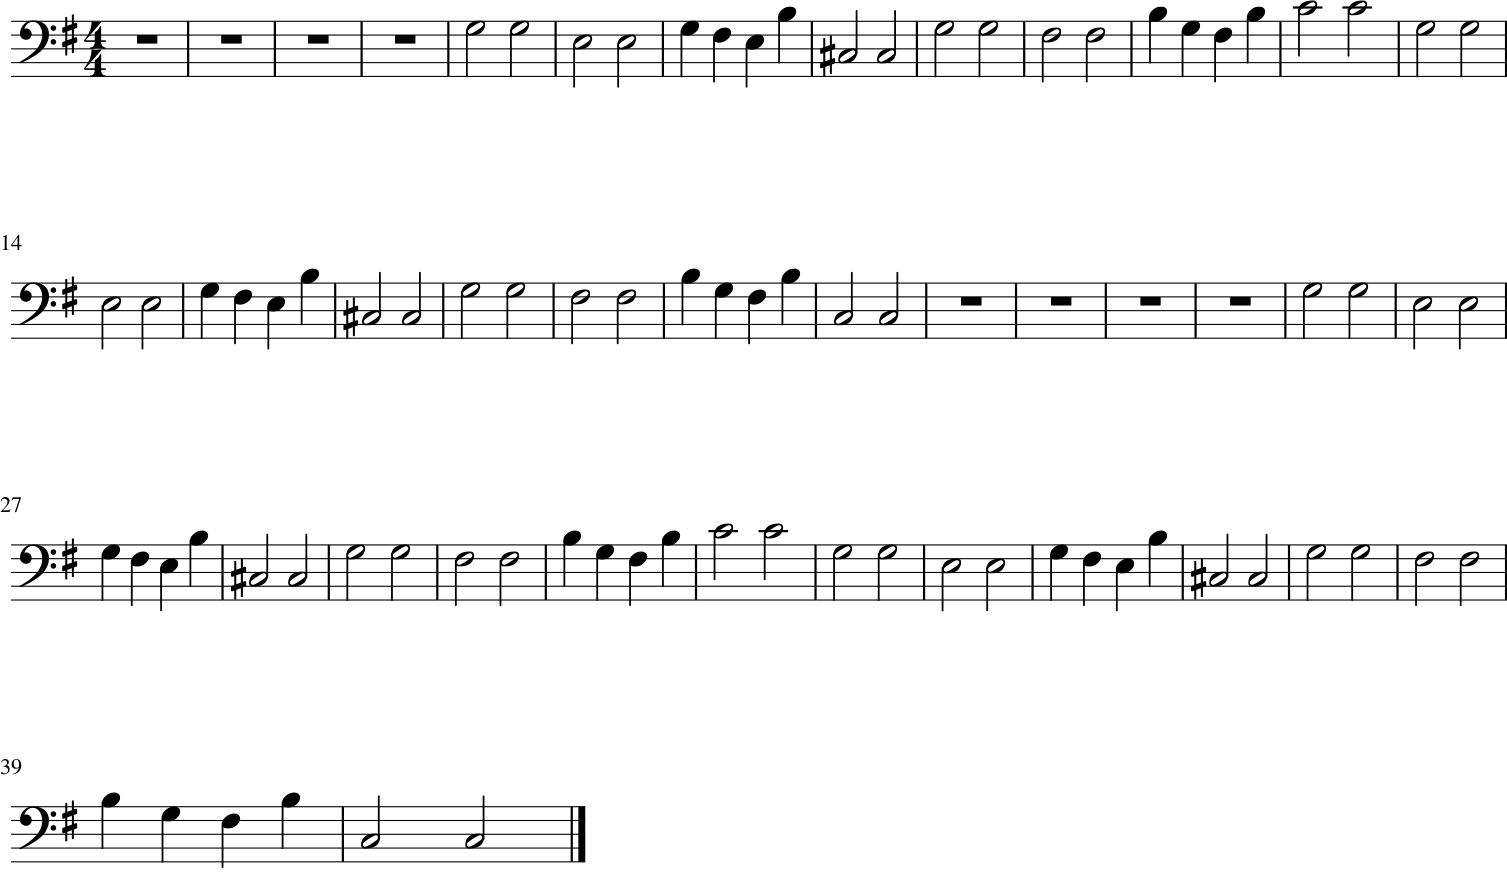

getting notes


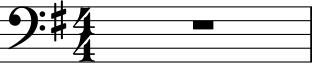

0
getting notes


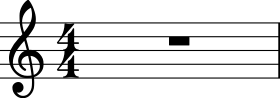

0
getting notes


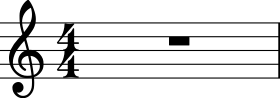

0
getting notes


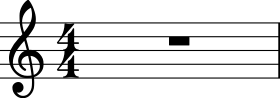

0
getting notes


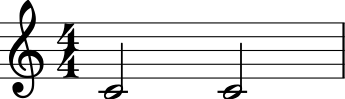

2
Parsing ../../data/pokemon/Pokemon - Littleroot Town.mid
Transposing from F major to C-major
VOICE------------------


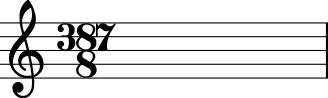

VOICE------------------


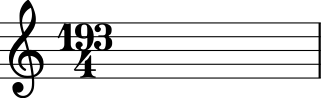

PART----------------


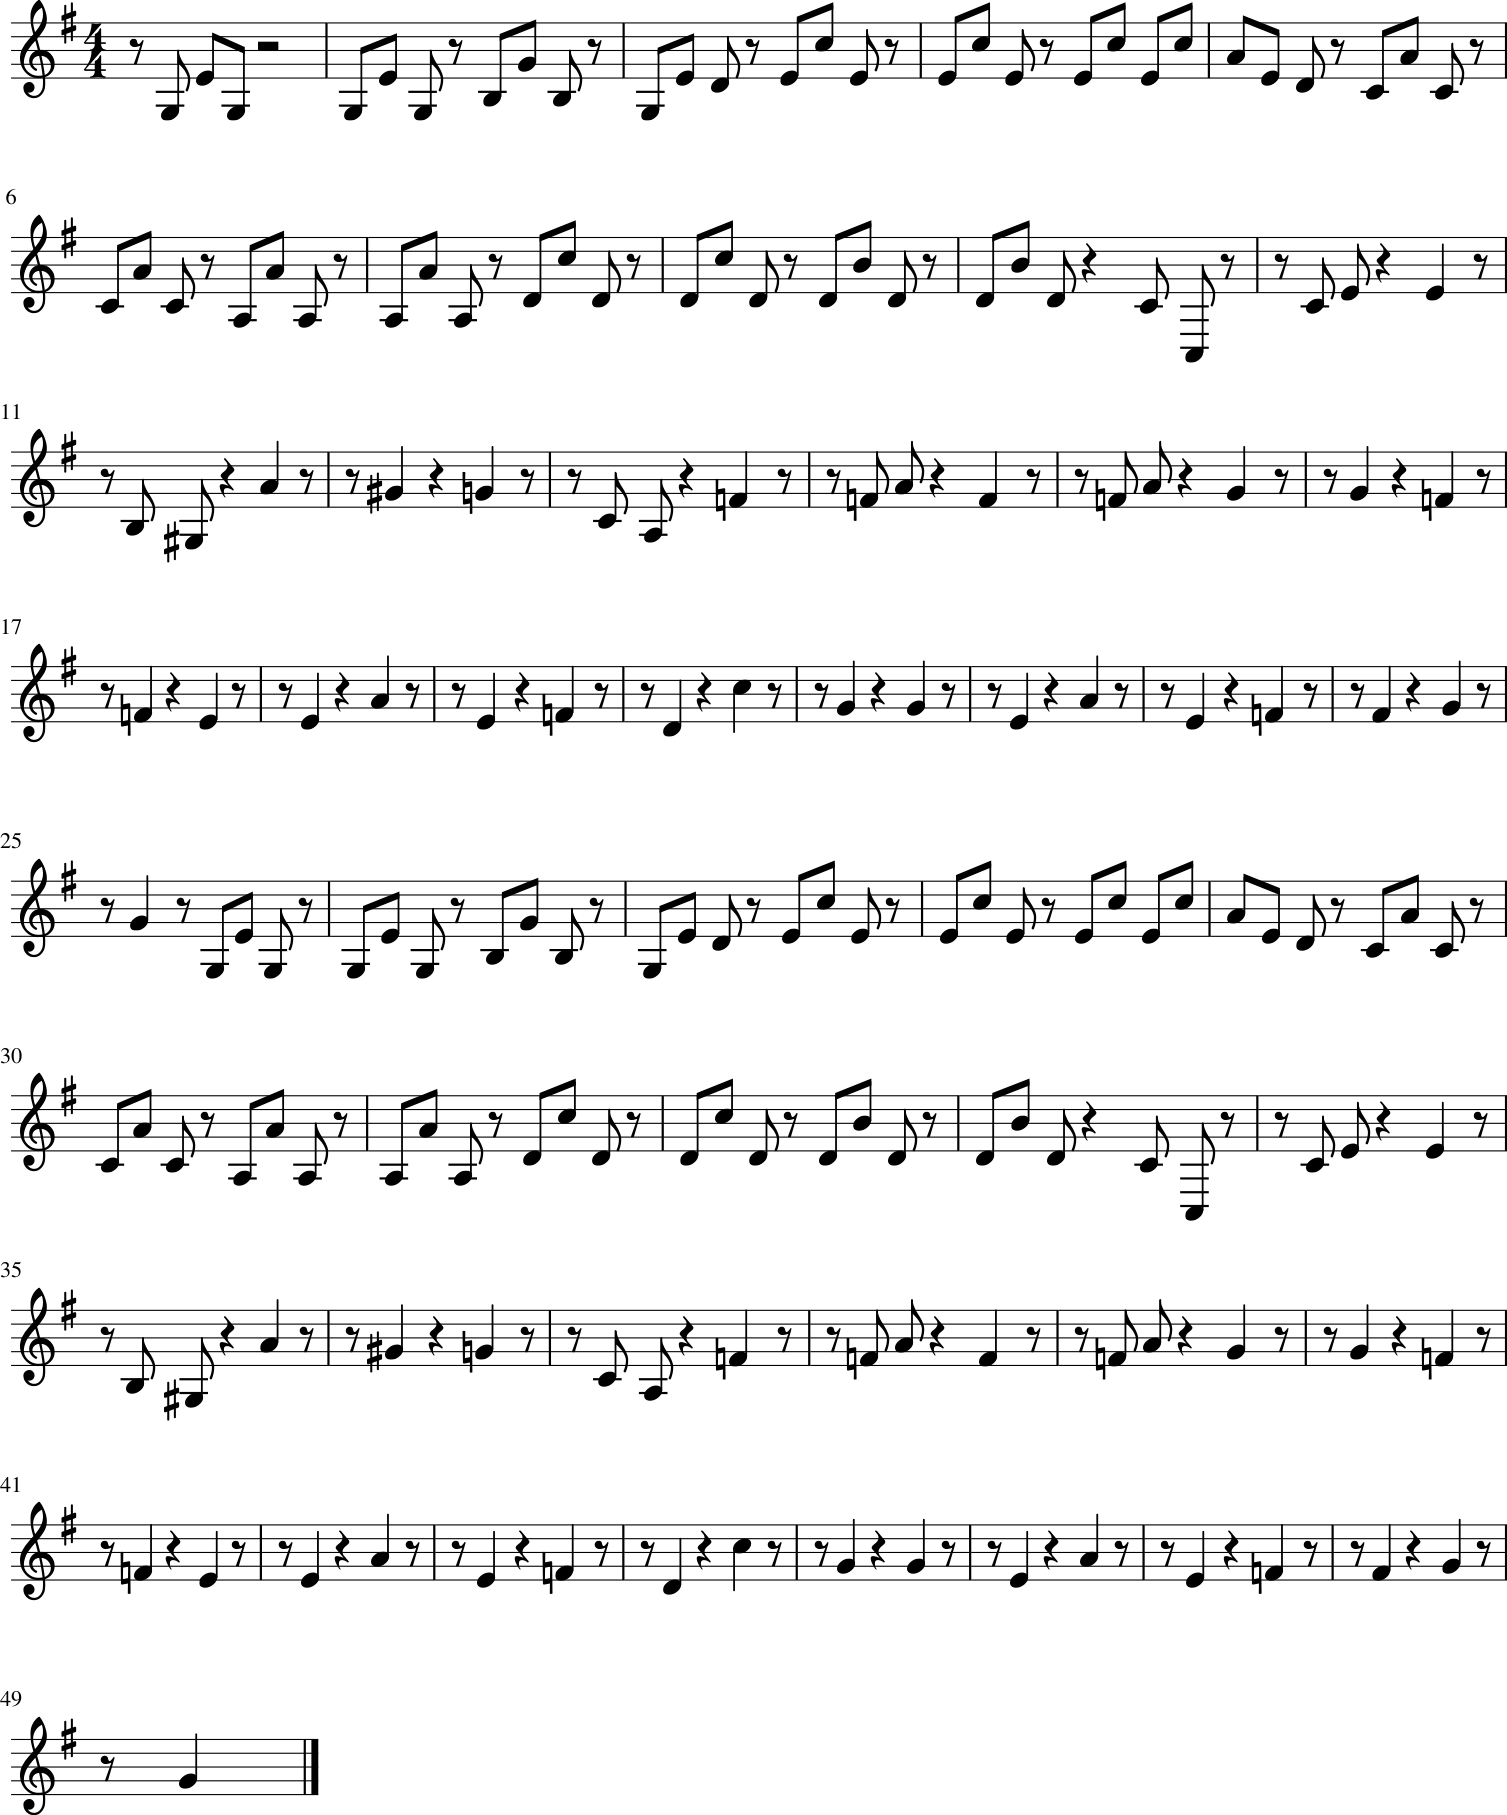

getting notes


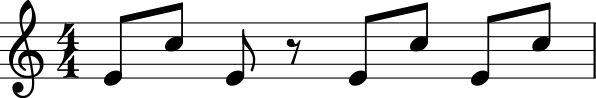

7
Parsing ../../data/pokemon/Pokemon Black 2White 2 - Cave of Being.mid
Transposing from F major to C-major
PART----------------


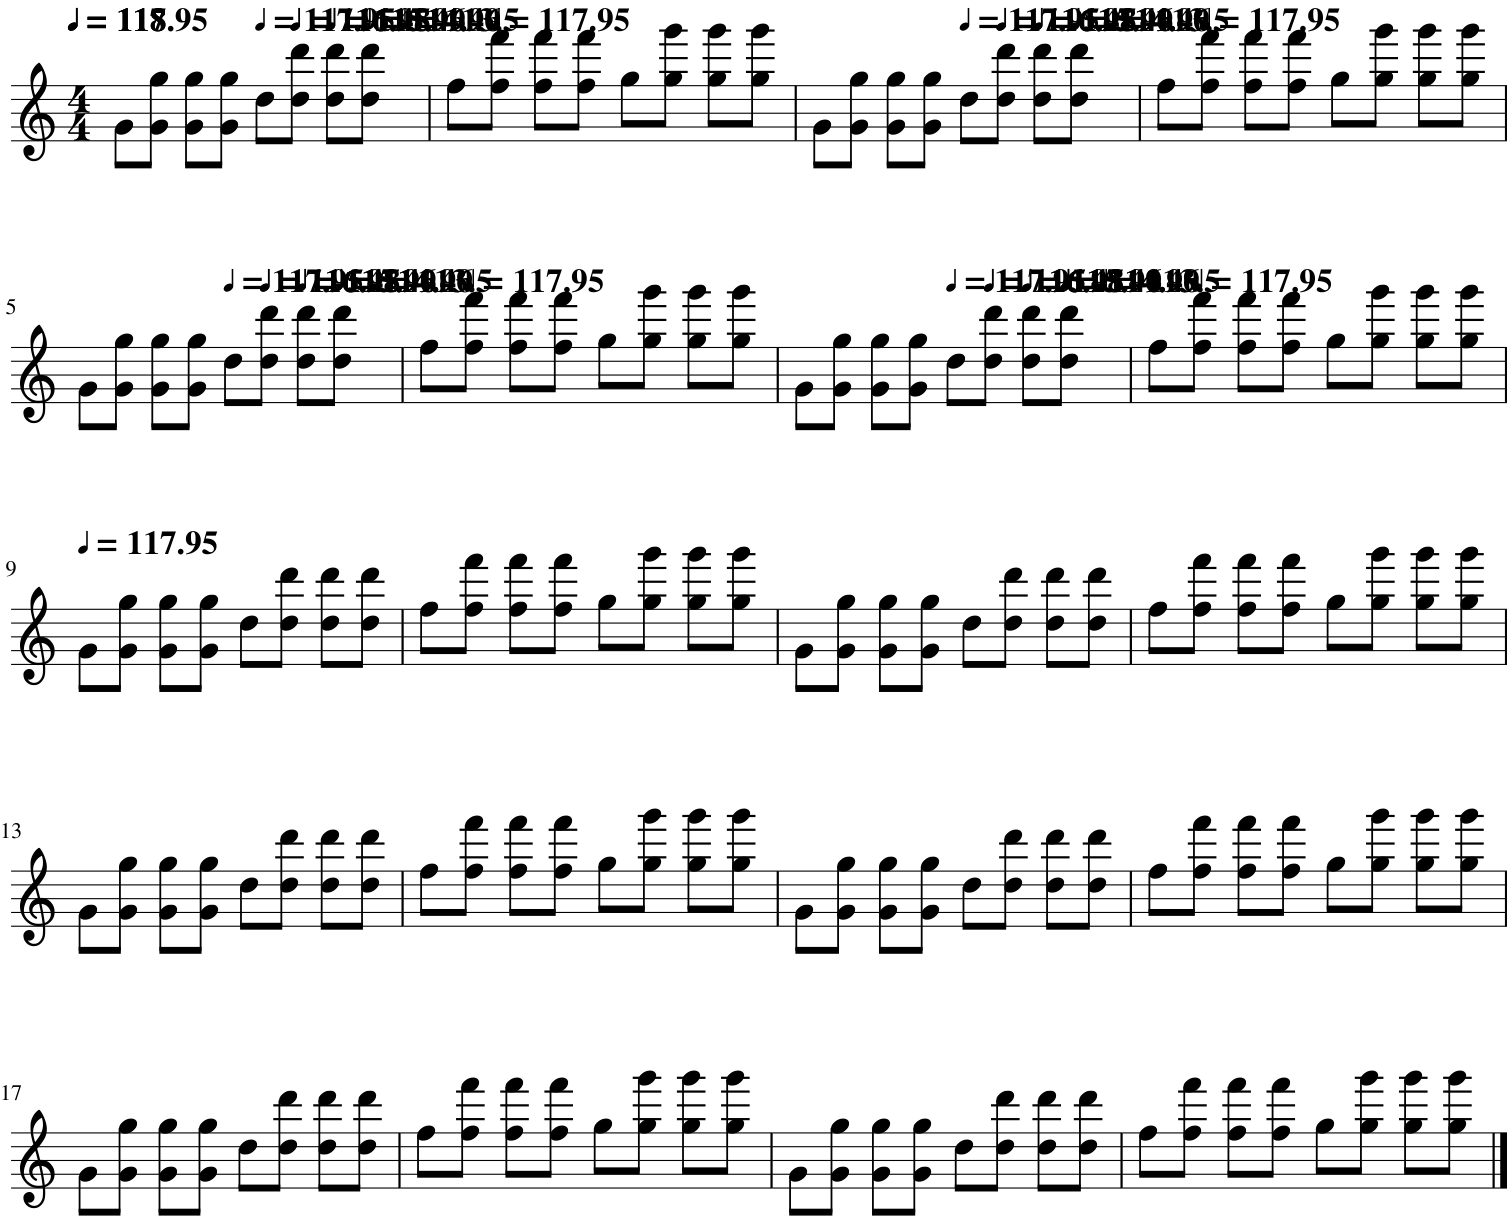

PART----------------


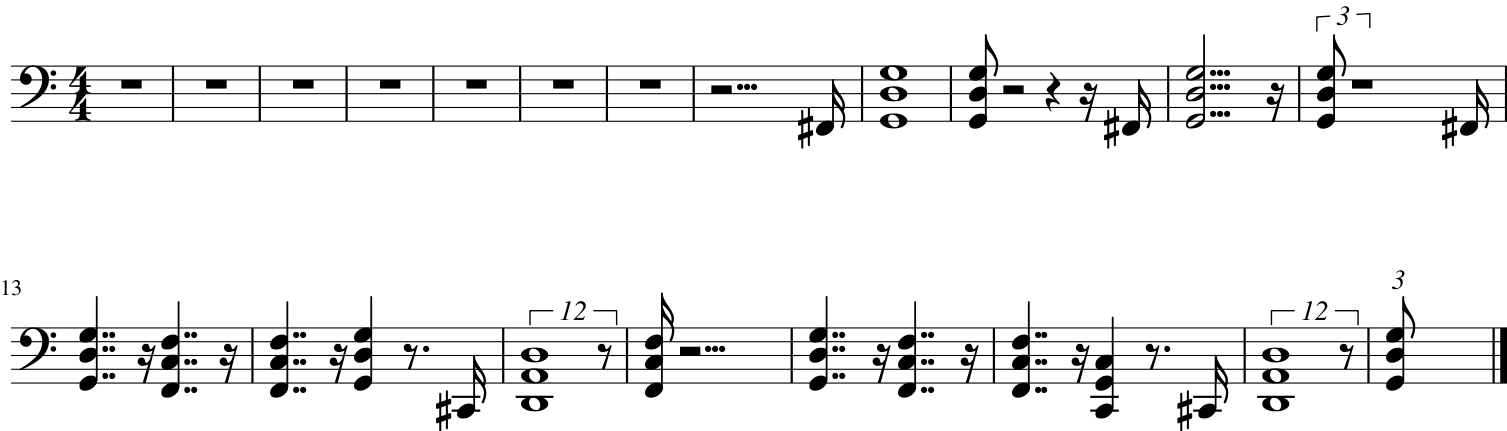

getting notes


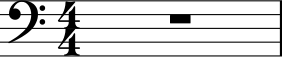

0
getting notes


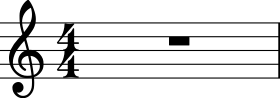

0
getting notes


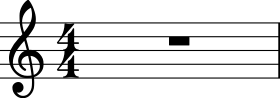

0
getting notes


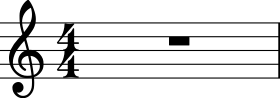

0
getting notes


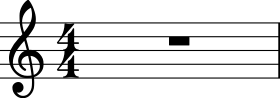

0
getting notes


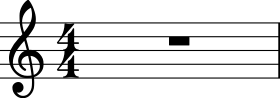

0
getting notes


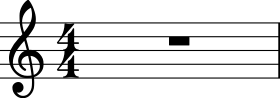

0
Parsing ../../data/pokemon/Pokemon Black 2White 2 - Join Avenue  Greeting.mid
Transposing from G major to C-major
VOICE------------------


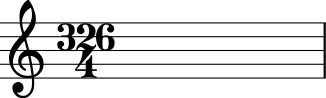

VOICE------------------


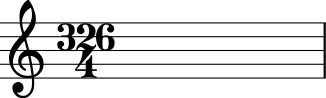

VOICE------------------


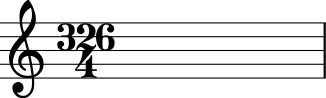

VOICE------------------
Parsing ../../data/pokemon/Pokemon HeartGoldSoulSilver - Viridian Forest.mid
Parsing ../../data/pokemon/Pokemon RubySapphireEmerald - Lilycove City.mid
Transposing from B major to C-major
Parsing ../../data/pokemon/Pokemon RubySapphireEmerald - Trick House.mid
Transposing from F# major to C-major
VOICE------------------
Parsing ../../data/pokemon/Pokemon RedBlueYellow - Wild Pokemon Battle.mid
Parsing ../../data/pokemon/Pokemon RubySapphireEmerald - Abandoned Ship.mid
Transposing from C# major to C-major
Parsing ../../data/pokemon/Pokemon XY - Route 4567.mid
Parsing ../../data/pokemon/Pokemon XY - The Sycamore Pokemon Lab.mid
Parsing ../../data/pokemon/Pokemon XY - Together with Shauna.mid
minor


KeyboardInterrupt: 

In [18]:
createDataset("../../data/pokemon/")

# ABCDEFGHIJKMNOPQRSTUVWXY
# createDataset(f"./gdrive/My Drive/training_data/130000MIDI/130000MIDI/A/")

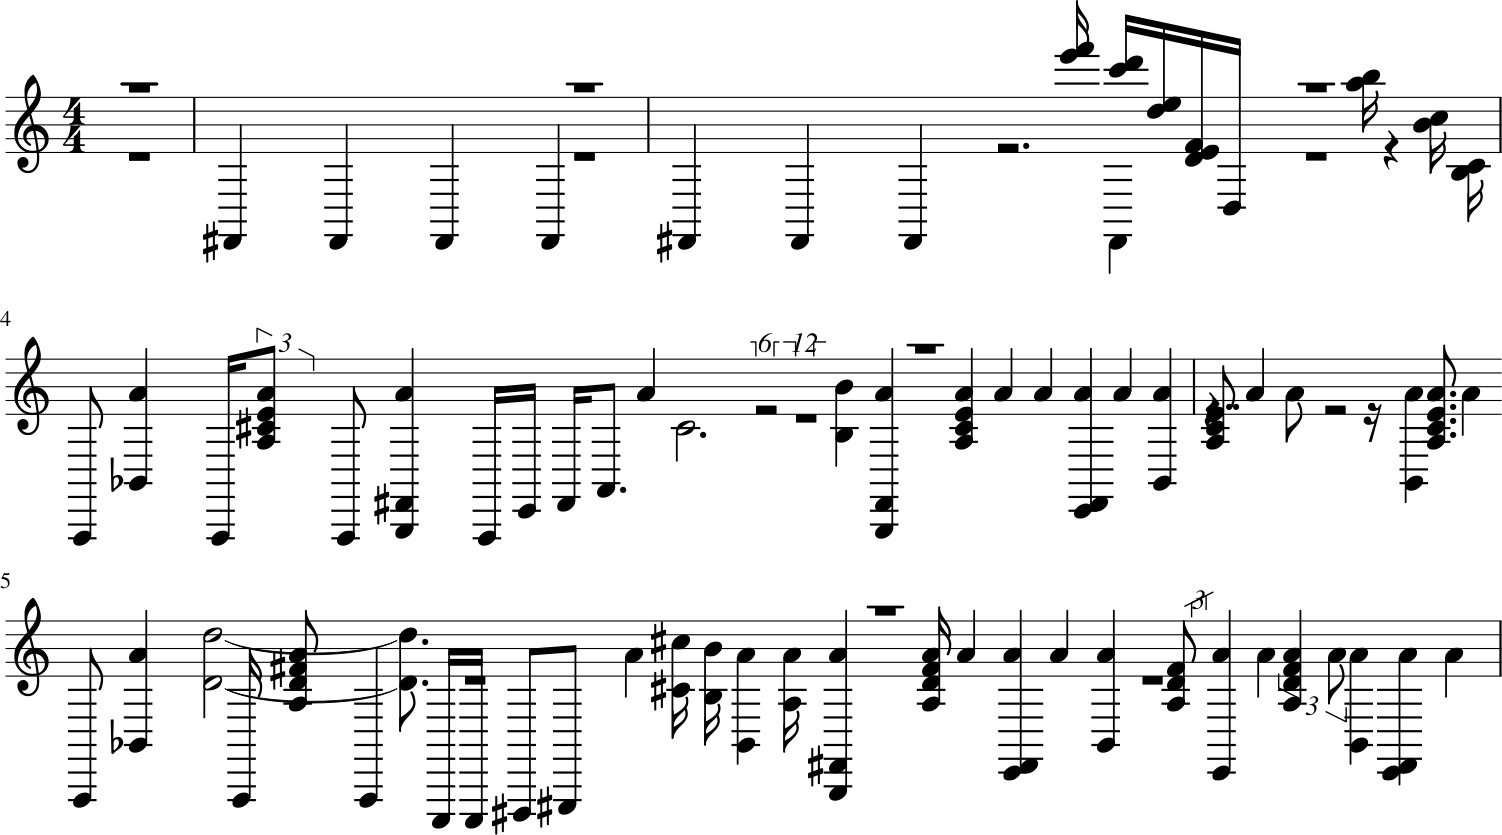

0


In [40]:
midi = converter.parse("../../data/selected/abba_-_dancing_queen.mid")

midi.parts[0].measures(0, 5).show()
print(len(midi.parts[0].measures(0, 5).notes))
# for measure in midi.voices[0].parts[0].measures(0, 5):
#     print(len(measure.notes))